In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import files
data = files.upload()

Saving Dummy_5000_Employee_Details_Dataset.csv to Dummy_5000_Employee_Details_Dataset (1).csv


In [5]:
data = pd.read_csv('Dummy_5000_Employee_Details_Dataset (1).csv')

# Preprocessing

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          5000 non-null   int64  
 1   Name                5000 non-null   object 
 2   Address             5000 non-null   object 
 3   Salary              5000 non-null   float64
 4   DOJ                 5000 non-null   object 
 5   DOB                 5000 non-null   object 
 6   Age                 5000 non-null   int64  
 7   Sex                 5000 non-null   object 
 8   Dependents          4877 non-null   float64
 9   HRA                 5000 non-null   float64
 10  DA                  5000 non-null   float64
 11  PF                  5000 non-null   float64
 12  Gross Salary        5000 non-null   float64
 13  Insurance           5000 non-null   object 
 14  Marital Status      5000 non-null   object 
 15  In Company Years    5000 non-null   int64  
 16  Year o

In [7]:
data.duplicated().sum()

0

In [8]:
data.isnull().sum()

,0
Unnamed: 0,0
Name,0
Address,0
Salary,0
DOJ,0
DOB,0
Age,0
Sex,0
Dependents,123
HRA,0


In [80]:
# Fill missing values for string features with the most frequent value
string_features = data.select_dtypes(include=['object']).columns
for feature in string_features:
  data[feature] = data[feature].fillna(data[feature].mode()[0])

# Fill missing values for integer features with the median value
int_features = data.select_dtypes(include=['int64', 'float64']).columns
for feature in int_features:
  data[feature] = data[feature].fillna(data[feature].median())

In [14]:
data.isnull().sum()

,0
Unnamed: 0,0
Name,0
Address,0
Salary,0
DOJ,0
DOB,0
Age,0
Sex,0
Dependents,0
HRA,0


In [15]:
data.to_csv('employee_dataset_clean.csv')
files.download('employee_dataset_clean.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
# Convert 'DOJ' and 'DOB' to datetime
data['DOJ'] = pd.to_datetime(data['DOJ'])
data['YearDOJ'] = data['DOJ'].dt.year
data['DOB'] = pd.to_datetime(data['DOB'])
data['YearDOB'] = data['DOB'].dt.year

In [42]:
data2 = data.copy()

In [44]:
# Encode the categorical columns
le_Insurance = LabelEncoder()
le_Marital_Status = LabelEncoder()
le_Department  = LabelEncoder()
le_Position  = LabelEncoder()
le_Sex = LabelEncoder()

data2['Sex1'] = le_Sex.fit_transform(data2['Sex'])
data2['Insurance1'] = le_Insurance.fit_transform(data2['Insurance'])
data2['Marital Status1'] = le_Marital_Status.fit_transform(data2['Marital Status'])
data2['Department1'] = le_Department.fit_transform(data2['Department'])
data2['Position1'] = le_Position.fit_transform(data2['Position'])

In [45]:
data2 = data2.drop(['Name', 'Address', 'DOJ', 'DOB', 'Sex', 'Insurance', 'Marital Status', 'Department', 'Position'], axis=1)

# Data Information

In [46]:
data2.head()

,Unnamed: 0,Salary,Age,Dependents,HRA,DA,PF,Gross Salary,In Company Years,Year of Experience,YearDOB,YearDOJ,Sex1,Insurance1,Marital Status1,Department1,Position1
0,0,149289.04,53,2.0,8776.096,35233.666375,22142.724765,171156.077610,26,32,1971,1998,2,0,3,4,29
1,1,69761.64,26,0.0,9302.836,16464.425985,10347.127918,85181.774067,3,5,1997,2020,1,0,2,1,9
2,2,107633.14,44,2.0,13357.686,25402.468564,15964.273028,130429.021537,3,23,1979,2020,0,0,0,3,35
3,3,147408.65,58,1.0,6026.135,34789.876034,21863.823124,166360.837910,17,37,1966,2007,1,0,1,0,1
4,4,53447.06,31,2.0,7554.294,12614.026326,7927.330359,65688.049967,7,10,1992,2017,1,1,1,4,30


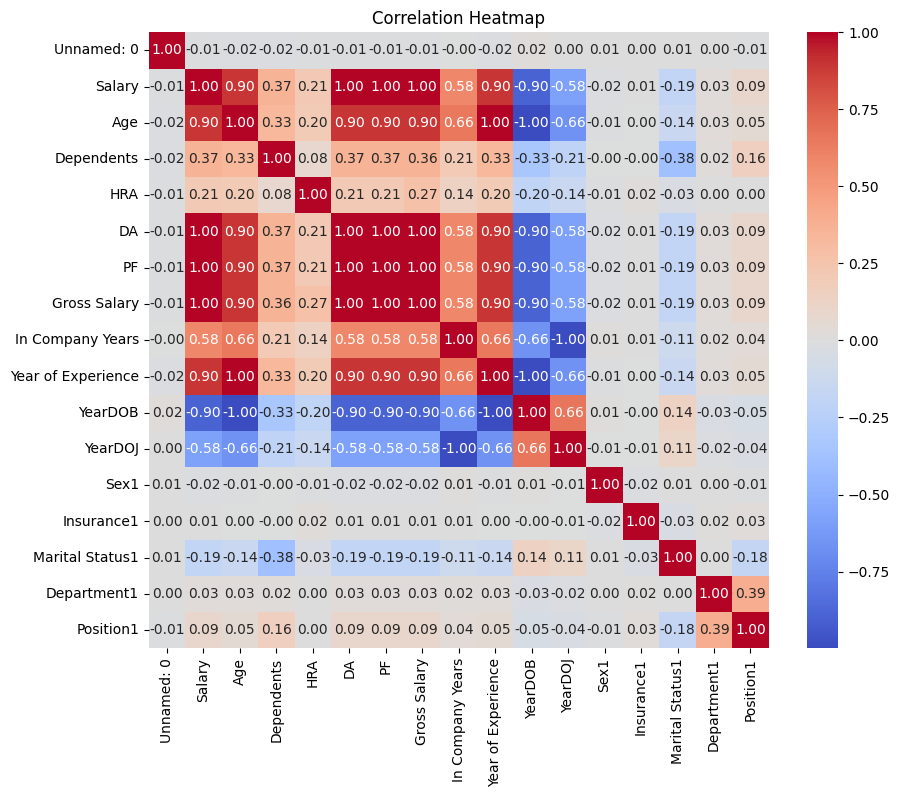

In [47]:
correlation_matrix = data2.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [79]:
data2['Salary'].describe()

,Salary
count,5000.000000
mean,93861.627080
std,33931.869545
min,15042.700000
25%,70556.305000
50%,96270.790000
75%,121182.540000
max,149991.340000


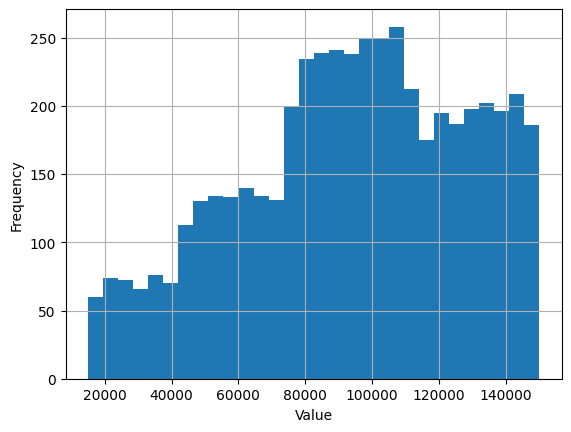

In [48]:
data2['Salary'].hist(bins=30)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Data Prediction Model

## Linear Regression

In [70]:
X = data2.drop(['Salary'], axis=1)
Y = data2['Salary']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("cross-validation:", model.score(X_test, Y_pred))

Mean Squared Error: 8.5825944252787e-22
R-squared: 1.0
cross-validation: 1.0


## Random Forest

In [72]:
rand = RandomForestRegressor(n_estimators=100, random_state=0, oob_score=True)

rand.fit(X_train, Y_train)

pred = rand.predict(X_test)

mse = mean_squared_error(Y_test, pred)
r2 = r2_score(Y_test, pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("cross-validation:", cross_val_score(rand, X_test, pred, cv=3).mean())

Mean Squared Error: 1170.5318179107392
R-squared: 0.9999989796772905
cross-validation: 0.9999578489500407


## Decision Tree

In [73]:
dec = DecisionTreeRegressor(random_state=0)

dec.fit(X_train, Y_train)

y_pred = dec.predict(X_test)

mse = mean_squared_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("cross-validation:", cross_val_score(dec, X_test, pred, cv=3).mean())

Mean Squared Error: 4436.789905300014
R-squared: 0.9999961325634822
cross-validation: 0.9998539381659493


## XGBoost

In [74]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xgboost = xgb.XGBRegressor()

grid_search = GridSearchCV(xgboost, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, Y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 9], 'n_estimators': [50, 100, 200],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='neg_mean_squared_error')

In [75]:
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.9}
Best cross-validation score:  -39015.16592701203


In [78]:
best_model = grid_search.best_estimator_

Ypred = best_model.predict(X_test_scaled)

mse = mean_squared_error(Y_test, Ypred)
r2 = r2_score(Y_test, Ypred)
scores = cross_val_score(best_model, X_test_scaled, Ypred, cv=3).mean()

print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Cross-validation scores: ", scores)

Mean Squared Error: 36630.9754518961
R-squared: 0.9999680697136509
Cross-validation scores:  0.9998562063398925
